<div><img src='images/CR_Logo.png' width='350px' style='display:inline;vertical-align:middle;'><h1 style='display:inline;vertical-align:middle;font-size:100px;'>: Which Deck is Best?</h1></div>

### - Spencer Lutz

[Clash Royale](https://clashroyale.com/) is a free-to-play real-time strategy mobile game released by [Supercell](https://supercell.com/). After the success of their game [Clash of Clans](https://supercell.com/en/games/clashofclans/), they released Clash Royale in early 2016 using many of the same characters, items, and mechanics. In a match of Clash Royale, each player selects a deck of 8 'cards'. Each card corresponds to a character with unique stats and abilities. These cards cost 'elixir' to use, a currency that slowly replenishes throughout the match. The goal of the game is to use your cards to simultaneously destroy the opponent's towers and defend your own. Each player has a 'King Tower' which is flanked by two 'Princess Towers'. The player who destroys their opponent's 'King Tower' first wins. If time runs out, the player who has destroyed more of their opponent's Princess Towers wins.

<div style='width:100%;text-align:center;'>
    <img src='images/Game1.png' width=300px style='padding-right:20px;'>
    <img src='images/Game2.png' width=300pxstyle='padding-left:20px;'>
</div>

There are many different types of matches that occur in Clash Royale, but I will be focusing on Ladder matches. The Ladder, also known as Trophy Road, is the central focus of the game, making up most of the player's progression. Ladder matches are 1v1 matches in which the winner wins 'trophies' and the loser loses trophies. Players start with 0 trophies, and they gain more by winning matches. The Ladder is divided into 20 arenas, which players unlock by reaching a certain number of trophies (e.g. Arena 1 requires 0 trophies, Arena 2 requires 300, ... Arena 20 requires 7500). Once a player enters an arena, they can never drop below the required trophies for that arena. When a player unlocks a new arena, they also unlock 4 to 8 new cards that they can add to their deck. At the start of Arena 1, the player only has 8 cards available, so every deck is the same; however, as more cards are unlocked, decks become very customizable.

Currently, I am in Arena 15, but I have been using the same deck since Arena 7. It used to perform quite well, but now it's outdated, so my progress has begun to stagnate. There are dozens more cards available to me now, so I wanted to create a new deck, but decision anxiety is preventing me from committing to anything. How would I know if a deck is good enough? Should I use a popular deck or create my own? What if switching out a couple cards would make me the best player in the world? The best way to answer these questions is through data.

## Data Collection, Parsing, and Representation

There aren't a lot of datasets out there for Clash Royale matches, and the ones that exist are very outdated. This is an issue because Supercell recently [released](https://clashroyale.com/blog/release-notes/new-update-october-2022.html) new cards and mechanics, which would have meaningful effects on the data and conclusions. Thus, I chose to create my own by scraping Clash Royale's [developer API](https://developer.clashroyale.com/#/). This will allow me to get data on millions of matches from the past few days alone.

### Clan Approach

In Clash Royale, players can join a 'Clan' - a group of players that trade cards, chat, and fight wars against other Clans. My initial approach was to loop through hundreds of clans, get every player in each clan, and then scan their recent matches for Ladder matches fought since the most recent [balancing update](https://clashroyale.com/blog/release-notes/balance-changes.html) (December 7). (*Note: there was an update on December 11 that included a small balance change to one card, but since this was a very small change and I wanted to maximize data, I chose to include matches both before and after this update.*)

I first import `requests` to get the data, `datetime` to ensure matches were played after the 12/7 update, and `pandas` to use DataFrames.

In [112]:
import requests
from datetime import datetime
import pandas as pd

I create constants for the API URL, my API auth token and resulting auth header, and the cutoff time.

In [113]:
API_URL = 'https://api.clashroyale.com/v1'
API_TOKEN = # Auth Token Here
AUTH_HEADER = {'Authorization': f'Bearer {API_TOKEN}'}
CUTOFF_TIME = datetime(2022, 12, 8) # Midnight December 8

I define a helper function to convert time from the format used by the API into a `datetime` object.

In [114]:
def to_datetime(date_str):
    """ 
    Parameters:
        date_str (string): A date in the format given by the CR API
    Yields:
        date (datetime): The same date as a datetime object
    """
    
    return datetime.strptime(date_str, '%Y%m%dT%H%M%S.000Z')

Next, I create a function to return a list of clan tags. The `/clans` API endpoint returns information about clans, including the clan tag, which is a string that uniquely identifies a Clan. We will need this later. I choose to return clans with at least 40 members (max for a clan is 50) because the API requires at least one filter, and because this will help maximize the number of players I can get per call to the API.

In [664]:
def get_clans(num_clans):
    """ 
    Parameters:
        num_clans (int): The maximum number of clans to return tags for
    Yields:
        tags (list): List of clan tags
    """
    
    min_members = 40 # Clans with at least 40 members
    url = API_URL + f'/clans?minMembers={min_members}&limit={num_clans}'

    response = requests.get(url, headers=AUTH_HEADER).json()
    return [clan['tag'] for clan in response['items']] # Return clan tags

Players also have unique tags that we can use to identify them. Once we have clan information, we can use the Clan's tag to generate a list of the tags of each member using the `/clans/{tag}/members` API endpoint. (*Note: `%23` and `[1:]` in any of the following code is because player and clan tags are of the format `#XXXXXXXX` (where X are alphanumeric), and that `#` needs to be URL encoded. Easier in my opinion to remove the `#` and add `%23` than to URL encode the entire string.*)

In [116]:
def player_tags_from_clan(clan_tag):
    """
    Parameters:
        clan_tag (string): The tag of the clan to search
    Returns:
        tags (list): The tags of valid players in the clan
    """
    
    url = API_URL + f'/clans/%23{clan_tag[1:]}/members' # API call to get clan members
    response = requests.get(url, headers=AUTH_HEADER).json()

    tags = [] # List to store tags in 
    for player in response['items']: # Loop through members
        # If member has not been online since the update, no point in getting their matches
        if to_datetime(player['lastSeen']) >= CUTOFF_TIME:
            tags.append(player['tag'])

    return tags

Now that we have players, we can easily get information about their recent battles. Supercell stores up to 35 battles for each player, which we can access using the `/players/{tag}/battlelog` API endpoint.

In [117]:
def battles_from_player(player_tag):
    """
    Parameters:
        player_tag (string): The tag of the player to search
    Returns:
        battles (list): The player's recent battles
    """
    
    url = API_URL + f'/players/%23{player_tag[1:]}/battlelog'

    return requests.get(url, headers=AUTH_HEADER).json()

For each battle, we need to specify what data to put in our dataframe and how to parse it. I first filter out any battles that aren't Ladder matches or that occurred before the recent update. I choose to keep the time information, the trophy count, deck, and score for both players, whether or not the player won, and an ID to uniquely identify each battle by its time and player tag. (The assumption is that no two matches will be played by the same player at the same time, leading to a unique value). We then add this to a 1-row dataframe and append it to an existing dataframe for every match.

In [118]:
def add_battle_to_df(df, battle):
    """
    Parameters:
        df (DataFrame): DataFrame to accumulate match info
        battle (dictionary): Match information returned from the CR API
    Returns:
        df (DataFrame): df with an added row containing the new battle's information
    """

    if battle['gameMode']['name'] != 'Ladder': # Verify ladder match
        return df
    
    time = to_datetime(battle['battleTime']) 
    if time < CUTOFF_TIME: # Check if match is after most recent update
        return df
    
    row = pd.DataFrame() # Create row to append
    
    row['time'] = [time] # Add time column
    
    # Get player and opponent data
    player = battle['team'][0]
    opponent = battle['opponent'][0]
    try: # Sometimes starting trophies is not listed for some reason
        row['player_trophies'] = player['startingTrophies']
        row['opponent_trophies'] = opponent['startingTrophies']
    except: # In this case we want to ignore the data
        return df

    # Get name of cards for decks on each side
    player_deck = [c['name'] for c in player['cards']]
    opponent_deck = [c['name'] for c in opponent['cards']]
    # Convert to tuple and sort so elements are hashable, compatible with groupby
    row['player_deck'] = [tuple(sorted(player_deck))]
    row['opponent_deck'] = [tuple(sorted(opponent_deck))]

    # Get final score for both sides and whether player won
    row['player_score'] = player['crowns']
    row['opponent_score'] = opponent['crowns']
    row['win'] = 1 if player['crowns'] > opponent['crowns']\
                    else 0 if player['crowns'] < opponent['crowns']\
                    else None

    # Generate a unique ID for this battle
    row['battle_id'] = hash(battle['battleTime'] + player['tag'])
    
    return pd.concat([df, row], ignore_index=True) # Add row to DataFrame

Now I can tie all these together into a single nested loop. I keep a DataFrame `battles` with every row that's added. Note that for every battle, I add the battle both from the player's perspective and from the opponent's perspective. This is to make analysis much easier later on.

In [ ]:
battles = pd.DataFrame()

# Loop through clans, players, matches
for clan_tag in get_clans(1000):
    for player_tag in player_tags_from_clan(clan_tag):
        for battle in battles_from_player(player_tag):
            battles = add_battle_to_df(battles, battle) # Add battle

            # Swap positions
            player, opponent = battle['team'], battle['opponent']
            battle['team'], battle['opponent'] = opponent, player

            battles = add_battle_to_df(battles, battle) # Add swapped battle

In [663]:
len(battles)

297254

This gives a good amount of data - around 300,000 matches. This is good, but for better results, I want somewhere on the order of a few million matches. Unfortunately, the API endpoint for getting clans caps the number of clans returned at 896 for some reason (I know that this isn't all of the clans because my clan has 50 members and it is never listed in the results). Another drawback of this approach is that matches are unevenly distributed across trophy count - there were many more matches between players around 5000 trophies than there were between players around 500. (The reason for this is that prior to the recent major update, the end of the ladder was at 5000 trophies.)

### Spidering Approach

My second approach was to spider (or crawl) through matches. I first get a good number of matches using the approach above, but instead of saving the original data, I get the player tag and trophy count. I then use these values to get a tag for one player in every 100-trophy interval. Once I have these tags, I run a modified BFS (Depth-Limited BFS? Is that a thing?) on their battles. I first add these initial tags to a queue, and for each one, I get the tags for every player they've fought a battle against. I add each of these players to a separate queue and do the same thing for that queue, making sure to avoid duplicate players. This means the number of players I can query isn't limited by the API, and because players fight matches against other players of similar trophy count, I will likely get a much more even distribution of data.

I get the intervals I want using `range` and use them to form a list of `pd.Interval` objects that need to be matched with a player tag. This list will be depleted as intervals are paired with player tags, and we will stop searching once all intervals have an associated player (i.e. `len(missing_intervals) == 0`). Then I request the list of clans as before, but this time, instead of a high minimum member count, I choose a low minimum score. A clan's score is based on the trophy count of its members, so this will prevent us from ruling out players with fewer than 1000 trophies, who are less likely to be in a clan. I loop through these, and for the same reasons as mentioned prior, I make sure that the clan has a minimum trophy requirement of 0. I then go through each member and check if they are part of an interval for which a player is needed, as well as if they have any recent battles to spider from. I then add this player's tag to the `players` dictionary.

In [ ]:
intervals = range(0,7501,100) # Get trophy intervals
players = {} # Dict to map trophy interval to player tag
# List of intervals that do not yet have a player associated
missing_intervals = [pd.Interval(i, j, 'left') for i, j in zip(intervals, intervals[1:])]

# Fetch clan data
url = API_URL + f'/clans?minScore={1}&limit={1000}'
response = requests.get(url, headers=AUTH_HEADER).json()

for clan in response['items']: # Loop through clans
    if clan['requiredTrophies'] == 0: # Make sure there is no trophy requirement
        for player in player_tags_from_clan(clan['tag']): # Loop through clan members
            for interval in missing_intervals: # Check intervals
                if player['trophies'] in interval\
                        and len(battles_from_player(player['tag'])) > 0:
                    players[interval] = player['tag'] # Add to players
                    missing_intervals.remove(interval) # Remove from missing intervals
                    
    if len(missing_intervals) == 0: # If we have found enough players, stop searching
        break

Now that I have starting tags for each trophy level, I can start spidering from each of them. I put these tags in `current_queue`, and initialize `next_queue` to `[]`. I am using a weird version of BFS, because with vanilla BFS if I stop iterating at a certian number of battles, it is possible I am halfway through the queue, in which case I would have many times more battles for trophy levels in the lower half that was searched 1 layer deeper. This method ensures that I only stop searching when an entire layer has been searched.

As before, I initialize a DataFrame to store the battle data we get. I set the depth to 5, which at a rate of roughly 15 valid battles per player should result in a few million battles. For each layer, I loop through `current_queue` until it is empty. I make sure the tag is new, and then I get the battles from that tag. I add the opponent for each battle to `next_queue` and add its data (if the battle is valid) to the DataFrame. After each layer, I remove all duplicates and check to see if we have at least 1 million battles. If not, I set `current_queue` to `next_queue` and clear `next_queue` for the next iteration.

In [ ]:
current_queue = list(players.values()) # Tags we are currently iterating
next_queue = [] # List to store current_queue's descendants
seen = set() # Stores tags we have already visited
depth = 5 # How deep to traverse in the 'tree'
battles = pd.DataFrame() # Accumulates battle rows like before

for _ in range(depth): # Loop through each layer
    while len(current_queue) > 0:
        tag = current_queue.pop()
        if tag in seen: # Make sure tag has not been visited
            continue
        seen.add(tag)

        player_battles = battles_from_player(tag) # Get battles
        for battle in player_battles:
            next_queue.append(battle['opponent'][0]['tag']) # Add to queue

            battles = add_battle_to_df(battles, battle) # Add battle to the DataFrame
            player, opponent = battle['team'], battle['opponent'] # Swap
            battle['team'], battle['opponent'] = opponent, player
            battles = add_battle_to_df(battles, battle) # Add swapped battle

    battles = battles.drop_duplicates(subset=['battle_id']) # Remove duplicate battles

    if len(battles) > 1000000: # Check limit
        break
    
    current_queue = next_queue # Shift queues
    next_queue = []

*I ran this a few different times over the following days to keep gathering data.*

In [255]:
len(battles)

6203429

I think this is enough data to begin my analysis.

## Exploratory Data Analysis

Lets get our new imports: We need `pyplot`, `ticker`, `font_manager`, and `Line2D` from `matplotlib` for visualizing our data, and `display` and `HTML` from `IPython.display` to display cards.

In [256]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
from matplotlib.lines import Line2D
from matplotlib import font_manager
from IPython.display import display, HTML

In [258]:
SMALL_FONT = 8
MEDIUM_FONT = 10
LARGE_FONT = 13
BG_COLOR = '#CFE6FC'
LINE_COLOR = '#FFFFFF'
COLOR_1 = '#FF6450'
COLOR_2 = '#B160FC'

### Summary Statistics

First, we can get some quick summary statistics:

In [259]:
battles.describe()

,player_trophies,opponent_trophies,player_score,opponent_score,battle_id,win
count,6.203429e+06,6.203429e+06,6.203429e+06,6.203429e+06,6.203429e+06,6203047.0
mean,4.177939e+03,4.177939e+03,1.102455e+00,1.102456e+00,1.439181e+15,0.5
std,1.636007e+03,1.636007e+03,1.052663e+00,1.052663e+00,5.324576e+18,0.5
min,2.300000e+01,2.300000e+01,0.000000e+00,0.000000e+00,-9.223368e+18,0.0
25%,2.664000e+03,2.664000e+03,0.000000e+00,0.000000e+00,-4.608086e+18,0.0
50%,4.651000e+03,4.651000e+03,1.000000e+00,1.000000e+00,1.316196e+15,0.0
75%,5.569000e+03,5.569000e+03,2.000000e+00,2.000000e+00,4.612455e+18,1.0
max,7.500000e+03,7.500000e+03,3.000000e+00,3.000000e+00,9.223364e+18,1.0


We see that we have (count) battles.  We can see that the stats for `player_trophies` are roughly identical to the stats for `opponent_trophies`, and the same is true for scores. This is expected because we are storing each battle from both perspectives. This also causes the mean win value (0 or 1) to be almost exactly $\frac{1}{2}$, as well as its standard deviation. We see that the trophy counts for our players range from 23 to 7500, meaning we have battles from close to edges of the possible trophy levels.

### Matches by Trophy Level

To follow up, I want to look at the distribution of matches by trophy level. This will give us an idea of what skill level our players are at. To do this, I'll divide the matches into bins based on their trophy count.

In [260]:
bin_size = 30
intervals_30 = range(0, 7501, bin_size) # 30 Trophy Intervals
cut_battles = pd.cut(battles['player_trophies'], intervals_30, include_lowest=True, right=False)
battles['trophy_bin'] = cut_battles
match_counts = battles.groupby(by='trophy_bin')['battle_id'].count()

Now, lets plot the data. I'll change a few things to make the plots look better:

In [261]:
# Use the Clash Royale font
for font in font_manager.findSystemFonts(['images']):
    font_manager.fontManager.addfont(font)
plt.rcParams["font.family"] = "Supercell-Magic"

# Customize font sizes
plt.rc('font', size=8) 
plt.rc('axes', labelsize=10) 
plt.rc('axes', titlesize=11)
plt.rc('xtick', labelsize=8)  
plt.rc('ytick', labelsize=8) 
plt.rc('legend', fontsize=8)
plt.rc('figure', titlesize=13)

In [262]:
# Function to format axes by removing the borders and setting the background color
def format_ax(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color(LINE_COLOR)
    ax.tick_params(left=False)
    ax.set_facecolor(BG_COLOR)

Now we can plot our data. I'll use a bar chart to visualize:

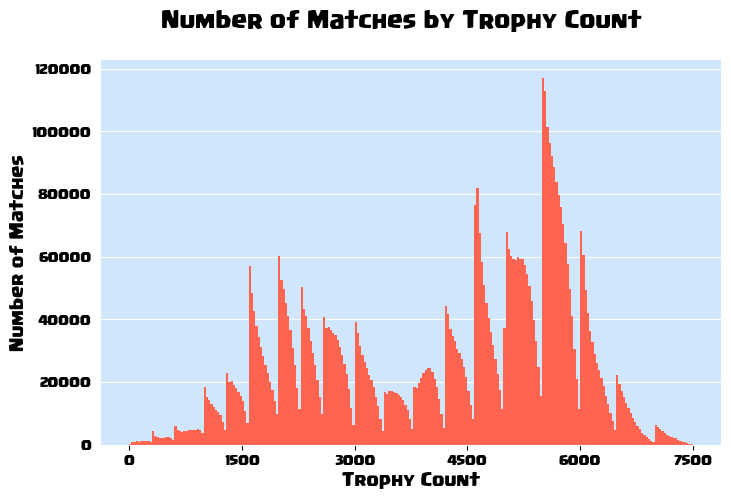

In [263]:
fig, ax = plt.subplots(figsize=(8,5)) # Create axes
format_ax(ax) # Format
ax.set_axisbelow(True) # Move axes to the back
ax.yaxis.grid(True, color=LINE_COLOR) # Include y lines
ax.xaxis.grid(False) # Exclude x lines
# Format the x axis by multiplying by bin size
formatter = tkr.FuncFormatter(lambda x, _: '{:.0f}'.format(x * bin_size))

# Create bars
ax.bar(range(len(intervals_30)-1), match_counts, width=1, align='edge', color=COLOR_1)
ax.set(xlabel='Trophy Count', ylabel='Number of Matches')

ax.xaxis.set_major_formatter(formatter) # Format x axis
fig.suptitle('Number of Matches by Trophy Count')

plt.plot(); # Plot the data

Overall, we see that there are many battles in the 1500-3000 trophy range, and many in the 4500-6000 range. The peaks in the 4500-6000 range are possibly due to the fact that before the recent major update, the ladder capped out at 5000, so many people are only now getting past 5000. I am not sure why 1500-3000 has more battles; it could be an artifact of my data collection strategy, or perhaps there is some reason that many players hover in that range.

A major thing that I'm sure you've noticed is the sawtooth pattern. This exists because, as I mentioned previously, once a player enters an arena, they cannot fall below that level of trophies. Thus, players that lose more often than they win (players who are not skilled or levelled enough to complete the arena) will always hover around the lowest trophy count of their arena. It is less common for battles to occur in the higher trophy levels of an arena, because those that are successful enough to progress that far in the arena are likely skilled enough to move on to the next arena.

### Matches by Deck

Next I want to look at how many people use each deck. This will give me an idea of whether players generally customize their decks or flock to a few popular decks.

In [264]:
users_per_deck = battles.groupby(by='player_deck')['battle_id'].count().sort_values(ascending=False)

t100_upd = users_per_deck[:100]
t1000_upd = users_per_deck[:1000]

I get the top 100 and top 1000 to show scale. There are hundreds of thousands of decks used in my dataset, so plotting all of them would take forever and prevent us from seeing the height of the important bars. 

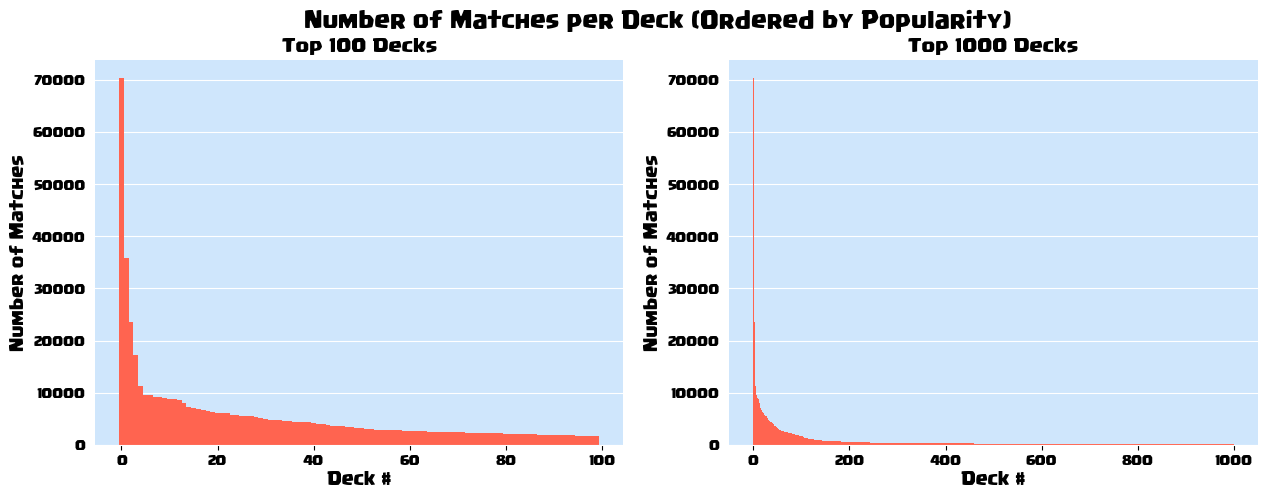

In [265]:
fig, axs = plt.subplots(1, 2, figsize=(15,5)) # Create axes
format_ax(axs[0]) # Format
axs[0].set_axisbelow(True) # Move axes to the back
axs[0].yaxis.grid(True, color=LINE_COLOR) # Include y lines
axs[0].xaxis.grid(False) # Exclude x lines
format_ax(axs[1])
axs[1].set_axisbelow(True) # Move axes to the back
axs[1].yaxis.grid(True, color=LINE_COLOR) # Include y lines
axs[1].xaxis.grid(False) # Exclude x lines

# Create bars
axs[0].bar(range(100), t100_upd, width=1, color=COLOR_1)
axs[0].set(xlabel='Deck #', ylabel='Number of Matches', title='Top 100 Decks')

axs[1].bar(range(1000), t1000_upd, width=1, color=COLOR_1)
axs[1].set(xlabel='Deck #', ylabel='Number of Matches', title='Top 1000 Decks')

fig.suptitle('Number of Matches per Deck (Ordered by Popularity)')

plt.plot(); # Plot the data

We can see that this resembles a power law distribution - A few decks account for many matches, while many decks only have a few matches. In the first graph, we see that the most popular deck was used in over 70000 matches, which is around 1.1%. This may seem small, but considering that there are over 400 billion possible decks, 1.1% shows huge popularity. In the second graph, we can see the true scale of the most popular deck in comparison to the others.

### Most Popular Decks

So what is this most popular deck? Lets look at the 8 most popular decks - I'm curious if the 2nd, 3rd, ... most popular decks are just variations of the number 1, or if they are popular in their own right. To do this, I want to visualize the cards more intuitively. I'll first get the image URLs for each card.

In [269]:
# Fetch the cards from the API
cards = requests.get(API_URL + '/cards', headers=AUTH_HEADER).json()

# Build a dictionary of card names to their icon URLs
card_urls = {}
for card in cards['items']:
    card_urls[card['name']] = card['iconUrls']['medium']

Now I'll define a function that displays a list of cards for us, and a function to convert a string representing a tuple of cards into a list that can be passed into `print_cards`. I use HTML in `print_cards` because displaying the images normally puts them each on a new line, which is horrible to look at. With HTML I can customize them to be all on one line. Additionally, I define a function to print text in the Clash Royale font.

In [339]:
def print_cards(cards):
    htmlstr = '<div>' # Initialize empty div
    for card in cards: # Add inline card HTML image to div
        htmlstr += f'<img src="{card_urls[card]}" width="60px" title="{card}" style="display:inline;">'
    htmlstr += '</div>' # Close the div
    display(HTML(htmlstr)) # Display the string

def deckstr_to_list(string):
    # Splits and strips each element into a list, returns
    return [s.strip()[1:-1] for s in string[1:-1].split(',')] 

def print_font(string):
    html_styles = "font-family:Supercell-Magic;margin:0px;" # Styles
    html = f'<p style="{html_styles}">{string}</p>' # Full HTML String
    display(HTML(html)) # Display the HTML

Now we can observe the most popular decks:

In [576]:
# Get decks sorted by popularity
decks_by_pop = battles.groupby(by='player_deck')['battle_id'].count().sort_values(ascending=False)
top_decks = decks_by_pop[:8] # Get the deck for the top 8 entries
for deck, matches in top_decks.items():
    print_font(f'{matches}:')
    print_cards(deckstr_to_list(deck)) # Display the cards
    print_font('-'*77) # Divider

(Hover over a card for a couple seconds to see its name.) The top deck doesn't seem to be similar to the others, but I do notice that decks 3, 6, and 8 are very similar. These decks are made up of cards earned in Arenas 1 and 2, so they are likely popular because there aren't many customization options at that level. I also see certain cards being used frequently, like [Fireball](https://clashroyale.fandom.com/wiki/Fireball) or [Ice Spirit](https://clashroyale.fandom.com/wiki/Ice_Spirit). Let's see what the most popular individual cards are:

In [272]:
count = {}
for deck in battles['player_deck']:
    for card in deckstr_to_list(deck):
        if card in count.keys():
            count[card] += 1
        else:
            count[card] = 1

Now we can display them:

In [279]:
cards_by_pop = sorted(list(count.keys()), key=lambda card: count[card], reverse=True)
top_cards = cards_by_pop[:10]
print_cards(top_cards)

These are not the cards I would have expected. The most popular, [Valkyrie](https://clashroyale.fandom.com/wiki/Valkyrie), is only in 2 of the top 8 decks, and the second most popular, [Skeleton Army](https://clashroyale.fandom.com/wiki/Skeleton_Army), isn't in any. It seems that people who make their own deck instead of choosing a popular one tend to use these cards more. I can attest; I made my own deck, and Valkyrie and Skeleton Army are both in it.

We looked at a few decks that are very popular in lower arenas, but I'm curious - what are the most popular decks for each trophy level? I assume the decks that are popular in Arena 1 won't necessarily be the most effective at Arena 20, and the decks used in Arena 20 aren't even accessible to players in Arena 1. To do this, we need to put the data into bins again. This time, I'll use a bin size of 500.

In [274]:
bin_size = 500
intervals_500 = range(0, 7501, bin_size) # Trophy bin counts
# Create bins of trophies
cut_battles = pd.cut(battles['player_trophies'], intervals_500, include_lowest=True, right=False)
battles['trophy_bin'] = cut_battles # Add column to DataFrame

Now we can group by these larger bins and get the mode for each bin.

In [275]:
decks_by_trophies = battles.groupby(by=cut_battles)['player_deck'].agg(pd.Series.mode)
bin_top_decks = {}
p_deck = ''
p_interval = None
for interval, deck in decks_by_trophies.items():
    if deck != p_deck:
        if p_interval != None:
            bin_top_decks[p_interval] = p_deck
        p_deck = deck
        p_interval = interval
    else:
        lb = p_interval.left
        rb = interval.right
        p_interval = pd.Interval(lb, rb, closed='left')
bin_top_decks[p_interval] = p_deck

In [575]:
for interval in bin_top_decks.keys():
    print_font(str(interval))
    print_cards(deckstr_to_list(bin_top_decks[interval]))
    print_font('-'*77) # Divider

We see that players from 0-2000 trophies frequently use the Arena 1 starter deck. Players from 2000-2500 trophies use a unique deck that's somewhat similar to the 0-2000 deck but takes advantage of some of the cards unlocked since then. 

Players from 3000-7000 frequently use the deck that we previously found to be the most popular overall. This deck is known as the [2.6 Hog Cycle](https://clashroyale.fandom.com/wiki/Deck:2.6_Hog_Cycle) deck, named for the [Hog Rider](https://clashroyale.fandom.com/wiki/Hog_Rider) card and the fact that its cards use on average 2.6 elixir. The deck from 2500-3000 seems to be almost exactly the same, except they replace [The Log](https://clashroyale.fandom.com/wiki/The_Log) with [Barbarian Barrel](https://clashroyale.fandom.com/wiki/Barbarian_Barrel) (which has a similar function), because The Log is not typically unlocked until 3400 trophies. (It is possible to unlock earlier, but less likely.) 

We don't see a new most popular deck until 7000 trophies, at the top of the ladder. This is probably because the 2.6 Hog Cycle is less effective at these higher levels compared to the cards unlocked at this stage, like the Champion [Mighty Miner](https://clashroyale.fandom.com/wiki/Mighty_Miner).

### Win Rate by Deck and Trophy Level

It would be interesting to see visually where each deck becomes less effective. To do this, we can graph the win rate of each of these decks by trophy count.

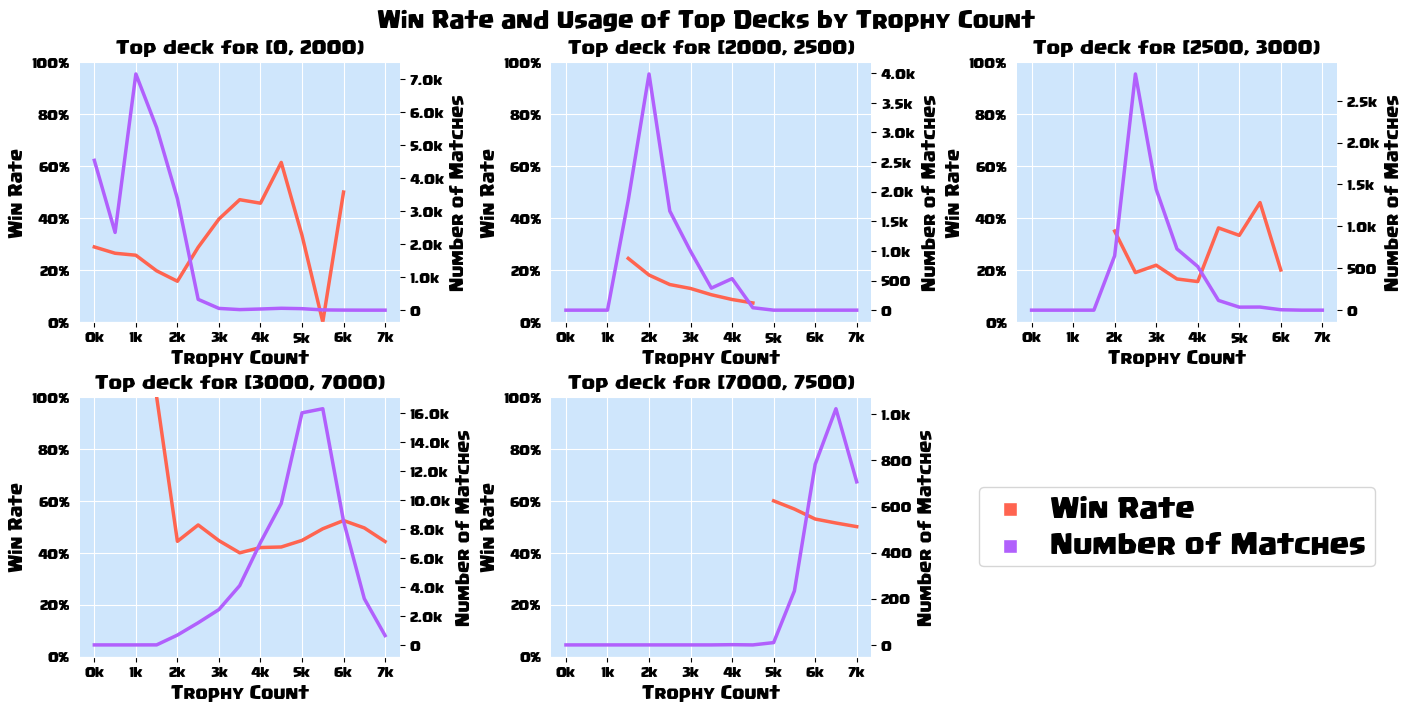

In [323]:
# Create axes and formatters
fig, axs = plt.subplots(2, 3, figsize=(14,7), constrained_layout=True)
x_formatter = tkr.FuncFormatter(lambda x, _: '{:.0f}k'.format(x * bin_size / 1000))
y_formatter = tkr.FuncFormatter(lambda y, _: '{:.0f}%'.format(y * 100.0))
y2_formatter = tkr.FuncFormatter(lambda y, _: '{:.1f}k'.format(y / 1000.0) if y > 999 else '{:.0f}'.format(y))

for i, interval in enumerate(bin_top_decks): # Loop through each top deck
    deck = bin_top_decks[interval]
    data_groupby = battles[battles['player_deck'] == deck].groupby(by='trophy_bin')
    win_rates = data_groupby['win'].mean() # Get win rates and number of matches
    num_users = data_groupby['battle_id'].count()

    tax = axs[i // 3, i % 3] # Get the current axes
    tax2 = tax.twinx()

    format_ax(tax) # Format
    tax.set_axisbelow(True) # Move axes to the back
    format_ax(tax2) # Format
    tax2.set_axisbelow(True) # Move axes to the back
    tax.yaxis.grid(True, color=LINE_COLOR) # Include y lines
    tax.xaxis.grid(True, color=LINE_COLOR) # Include x lines

    tax.plot(range(15), win_rates, color=COLOR_1, linewidth=2.5) # Plot win rate
    tax.set(xlabel='Trophy Count', ylabel='Win Rate', title=f'Top deck for {interval}', ylim=[0,1])
    tax.xaxis.set_major_formatter(x_formatter) # Format x axis
    tax.yaxis.set_major_formatter(y_formatter) # Format y axis
    
    tax2.plot(range(15), num_users, color=COLOR_2, linewidth=2.5) # Plot number of matches
    tax2.set_ylabel('Number of Matches')
    tax2.yaxis.set_major_formatter(y2_formatter) # Format y axis

# Create legend in the 6th axes
legend_elements = [Line2D([0], [0], marker='s', color='w', label='Win Rate', markerfacecolor=COLOR_1, markersize=10),
                   Line2D([0], [0], marker='s', color='w', label='Number of Matches', markerfacecolor=COLOR_2, markersize=10)]
axs[1,2].legend(handles=legend_elements, loc='center', prop={'size': 16})
axs[1,2].axis('off')

fig.suptitle('Win Rate and Usage of Top Decks by Trophy Count')
plt.show(); # Show figure

Interestingly, the first 3 decks don't seem to be very effective at the trophy levels where they're most used. [0, 2000) deck (the Arena 1 starter deck) seems to have a roughly 30% win rate in Arena 1, dropping to under 20% at 2000 trophies (Arena 7). After that, the deck doesn't get used much at all, so win rates there aren't statistically significant. Why is this deck used so frequently if it has such a low win rate? It could be because this is the default starter deck, and some players never bother to switch up their deck until they have a lot of new cards.

The [2000, 2500) deck does poorly as well, with less than a 20% win rate in that trophy range. I'm not sure why players would choose this deck. Maybe a popular content creator uses this deck? The [2500, 3000) deck (the budget 2.6 Hog Cycle) does poorly but is probably popular because players want to try using the 2.6 Hog Cycle as early as possible.

The [3000, 7000) deck (2.6 Hog Cycle) does pretty well, with a 40-50% win rate throughout all of its usage. I have a feeling it used to be more effective (I only have the past week's worth of data so I can't confirm), with a >50% win rate, but 2.6 Hog Cycle has been the prevailing deck (the 'meta') for many months at this point, so decks effective at countering it have likely grown in popularity. If its win rate continues to decrease, it may soon lose its status as the most popular deck. This cycle happens frequently in the Clash Royale meta.

Finally, the [7000, 7500) deck seems to have a roughly 50% win rate in that trophy interval. Players at the top of the ladder are probably more likely to pick a deck that has a high win rate.

### Best Decks for My Arena

I am currently in the [5000, 5500) interval (Arena 15). While 2.6 Hog Cycle is the most popular deck for this arena, I want to find the best deck. I obviously don't have data on all >400 billion decks - the majority of them have never been played. Thus, I'll be forced to use a deck that has been used in the past. As long as it has a more than 50% win rate, I'll be happy.

Let's first look at our decks, sorted by win rate in Arena 15.

In [572]:
# Get data for matches in Arena 15
arena_15_data = battles[battles['trophy_bin'] == pd.Interval(5000, 5500, closed='left')]
deck_win_rate = arena_15_data.groupby(by='player_deck')['win'].mean() # Get win rate
a15_top_5 = deck_win_rate.sort_values(ascending=False)[:5] # Get top 5 by win rate
for deck, win_rate in a15_top_5.items(): # Print the top 5
    print_font(f'Win Rate: {win_rate * 100}%')
    print_cards(deckstr_to_list(deck))
    print_font('-'*77) # Divider

Great, it looks like we found our top decks, all with 100% win rate. That was easy, right? Let's see how many times these decks were used:

In [573]:
for i, deck in enumerate(a15_top_5.index): # Loop through top 5
    # Get number of matches for each deck
    times_used = len(arena_15_data[arena_15_data['player_deck'] == deck])
    print_font(f'Deck {i+1}: {times_used}') # Print

Each deck was only used once. If they just happened to win that one match, they would instantly have a 100% win rate, which is the case here. How can we avoid this issue?

## Hypothesis Testing

We need to determine whether a deck's win rate is statistically significant. To start, we should define a null hypothesis. In this case, our null hypothesis is that a deck has a 50% win rate. We want to find decks where the mean win value is significantly greater than 50% - This is our alternative hypothesis.

We must keep in mind that we are working with binary data (1 = win, 0 = loss), not continuous or normally distributed data. In this case, we are comparing an observed proportion (win rate of a deck) with a theoretical proportion (50%). This calls for a [one proportion z-test](https://www.statology.org/one-proportion-z-test/). We want to know if our observed proportion is *greater* than the theoretical one, so we will be running a right-tailed test.

First, let's get our imports. We will be using `proportions_ztest` from `statsmodels`.

In [478]:
from statsmodels.stats.proportion import proportions_ztest

Next, let's get the number of matches and number of wins for each deck in Arena 15.

In [615]:
# Group by deck and aggregate sum and count statistics
deck_stats = arena_15_data.groupby(by='player_deck').agg({'win': ['sum', 'mean'], 'battle_id': ['count']})
deck_stats.columns = deck_stats.columns.map('_'.join)
deck_stats = deck_stats.reset_index()
deck_stats

,player_deck,win_sum,win_mean,battle_id_count
0,"('Archer Queen', 'Archers', 'Arrows', 'Giant S...",0.0,0.0,1
1,"('Archer Queen', 'Archers', 'Balloon', 'Bats',...",0.0,0.0,1
2,"('Archer Queen', 'Archers', 'Barbarians', 'Eli...",0.0,0.0,1
3,"('Archer Queen', 'Archers', 'Bats', 'Hog Rider...",1.0,1.0,1
4,"('Archer Queen', 'Archers', 'Bomber', 'Dart Go...",0.0,0.0,1
...,...,...,...,...
377484,"('Prince', 'Princess', 'Skeleton Army', 'Spark...",1.0,1.0,1
377485,"('Prince', 'Rage', 'Royal Giant', 'Skeleton Ar...",2.0,1.0,2
377486,"('Prince', 'Royal Ghost', 'Skeleton Army', 'Te...",0.0,0.0,2
377487,"('Prince', 'Royal Hogs', 'Skeleton Army', 'The...",0.0,0.0,1


Now we can run our z-test. We'll add a new column to our dataframe with the p-value of our test for each deck.

In [616]:
def add_p_val_col(df, h_0):

    def get_p_val(row):
        if row['win_sum'] / row['battle_id_count'] < h_0:
            return None # Eliminate bad values, don't run test
        else:
            _, p_val = proportions_ztest( # Run z test
                count=row['win_sum'], # Number of wins
                nobs=row['battle_id_count'], # Number of matches
                value=h_0, # Theoretical mean
                alternative='larger', # Observed mean hypothesized to be larger
                prop_var=h_0 # Variance
            )
            return p_val

    return df.apply(get_p_val, axis=1) # Apply to dataframe

In [618]:
deck_stats['p_val'] = add_p_val_col(deck_stats, 0.5) # Null hypothesis is 50%
deck_stats_05 = deck_stats.dropna()
deck_stats_05

,player_deck,win_sum,win_mean,battle_id_count,p_val
3,"('Archer Queen', 'Archers', 'Bats', 'Hog Rider...",1.0,1.0,1,0.158655
5,"('Archer Queen', 'Archers', 'Bomber', 'Hog Rid...",1.0,1.0,1,0.158655
6,"('Archer Queen', 'Archers', 'Cannon', 'Earthqu...",1.0,1.0,1,0.158655
7,"('Archer Queen', 'Archers', 'Cannon', 'Giant S...",1.0,1.0,1,0.158655
8,"('Archer Queen', 'Archers', 'Clone', 'Dart Gob...",1.0,1.0,1,0.158655
...,...,...,...,...,...
377479,"('Phoenix', 'Princess', 'Ram Rider', 'The Log'...",6.0,0.5,12,0.500000
377481,"('Poison', 'Prince', 'Princess', 'Ram Rider', ...",1.0,1.0,1,0.158655
377483,"('Prince', 'Princess', 'Ram Rider', 'Skeleton ...",1.0,0.5,2,0.500000
377484,"('Prince', 'Princess', 'Skeleton Army', 'Spark...",1.0,1.0,1,0.158655


In this case, the p-value represents the probability that a deck's actual win rate is less than or equal to 50%, given our observed data. Let's set our p-value limit at 0.005. I'll see what the most popular deck below this p-value is.

In [619]:
valid_decks = deck_stats_05[deck_stats_05['p_val'] < 0.005]
pop_3 = valid_decks.sort_values(by='battle_id_count', ascending=False)[:3]
for i, row in enumerate(pop_3.values):
    deck, _, win_rate, num_battles, p_val = row
    print_font(f'Deck #{i+1}: {"{:.2f}".format(win_rate * 100)}% Win Rate over {num_battles} matches.')
    print_font(f'\nP Value is {"{:.7f}".format(p_val)}.')
    print_cards(deckstr_to_list(deck))
    print_font('-'*77)

The top deck was used over 9000 times, with a consistently above 50% win rate. This is good, but 51.95% isn't exactly phenomenal. Deck #3 also looks promising, an dhas a 63% win rate, so I'll probably give that one a try.

What if we looked at the decks with the lowest p-values? These should theoretically have the highest likelihood of having an actual win rate above 50%.

In [620]:
t3_pval = deck_stats.sort_values(by='p_val')[:3]
for i, row in enumerate(t3_pval.values):
    deck, _, win_rate, num_battles, p_val = row
    print_font(f'Deck #{i+1}: {"{:.2f}".format(win_rate * 100)}% Win Rate over {num_battles} matches.')
    print_font(f'\nP Value is {"{:.7f}".format(p_val)}.')
    print_cards(deckstr_to_list(deck))
    print_font('-'*77)

The top deck won 24 of the 25 matches it was played in. That's a very good win rate with a solid sample size, so I will definitely try this one out. 

What if we raised the bar and changed our null hypothesis to a 80% win rate? Would this change our findings?

In [621]:
deck_stats['p_val'] = add_p_val_col(deck_stats, 0.8) # Null hypothesis is 50%
deck_stats_08 = deck_stats.dropna()

t3_pval = deck_stats_08.sort_values(by='p_val')[:3]
for i, row in enumerate(t3_pval.values):
    deck, _, win_rate, num_battles, p_val = row
    print_font(f'Deck #{i+1}: {"{:.2f}".format(win_rate * 100)}% Win Rate over {num_battles} matches.')
    print_font(f'\nP Value is {"{:.7f}".format(p_val)}.')
    print_cards(deckstr_to_list(deck))
    print_font('-'*77)

It looks like a higher expected proportion leads to lower p-values for the 100% win rate, low sample size decks. Perhaps Deck #1 is worth trying, as it was also Deck #3 in the 0.5 expectation test.

## Conlcuding Thoughts

We've decided on three decks that I should try, based on their win rates, popularity, and p-value:

In [646]:
pop_deck_05 = pop_3.values[2][0]
best_deck_05 = deck_stats_05.sort_values(by='p_val').head(1).values[0][0]
best_deck_08 = deck_stats_08.sort_values(by='p_val').head(1).values[0][0]
print_cards(deckstr_to_list(pop_deck_05))
print_cards(deckstr_to_list(best_deck_05))
print_cards(deckstr_to_list(best_deck_08))

### Conclusions and Recap

We can draw a few conclusions from our analysis. 

Firstly, we have learned that matches are clustered around the 1500-3000 trophy range and the 4500-6000 trophy range. Players are clustered around the start of arenas, typically in 300-500 trophy intervals, with the number of matches (and as a thus players) decreasing as trophy counts increase in an arena. The quantity of matches in my trophy interval of interest (5000-5500) makes data analysis easier for my purposes.

We also analyzed the distribution of matches per deck. The top few decks have thousands of times more matches than the rest of the decks. This raised the question of whether these decks are popular because of their effectiveness. We then looked at the most popular decks in particular, and saw that the 2.6 Hog Cycle and the Arena 1 starter deck were among the most used, with variations of the latter being used frequently. We also looked at the most popular cards, with many of them not being in the top decks. This suggests that those cards are more likely to be picked when players create custom decks.

We also looked at the most popular decks for each trophy level. Players from 0 to 2000 most frequently use the Arena 1 starter deck, players from 2000 to 2500 use a unique deck with more advanced cards, players from 2500 to 7000 use variations of the 2.6 Hog Cycle, and players above 7000 use another unique deck.

We also observed the win rates of each of these decks. The decks from 0 to 3000 have pretty low win rates, around 20%. They are probably only popular due to the fact that many players stick with the starting deck. The 2.6 Hog Cycle has a roughly 40-50% win rate for 3000-7000, which is pretty solid but could be better. It's probably lower due to the increased prevalence of decks that effectively counter it. The 7000+ trophy deck has about a 50% win rate, which is definitely solid for a popular deck. From this, we can conclude that the popularity of a deck does not necessarily correlate with its effectiveness.

We also analyzed the best decks by win rate, but we saw that they all had very few battles associated with them. Thus, we saw the importance of evaluating the statistical significance of our results. We ran hypothesis tests (one-proportion z-tests) in a few different ways and landed on 3 different decks to try out. I would suggest that the reader, if in the 5000-5500 trophy range, try these decks as well and gauge their effectiveness.

### Future Work

It could be valuable to examine stats for other gamemodes, like the Path of Legends or Clan War battles. It would also be useful to examine the effectiveness of decks against the 2.6 Hog Cycle, or whatever deck is most popular in the future.

Another interesting statistic could be the prevalence of certain decks over time. It would be good to confirm my hunch that the 2.6 Hog Cycle is losing prevalence, and it would be interesting to see what deck is poised to replace it.

### Takeaways

After reading this analysis, you should gain a better understanding of the mechanics of Clash Royale, what decks are best, how you might analyze the effectiveness and popularity of each deck, and hopefully a bit of knowledge about statistics. Maybe you'll be inspired to try Clash Royale yourself, and you'll use some of these statistics to your advantage. 

Thank you for reading my analysis.